# MDST Flint Project 7: Predicting whether service line material is lead


**Task**: Predicting whether service line material is lead. There is uncertainty in the type of service line materials, and usually there are two different service lines, public and private service lines. There are few houses where we know the material of service lines. It is two binary classification problem. Which may be correlated with each other. 
- Private Service line material is Lead or it is not Lead
- Public Service line material is Lead or it is not Lead

**Data**: Residential water testing data, parcel data.

**Questions**:

- What features are correlated with the public/private service line materials? 
- With how much accuracy we can predict whether public/private service line material is lead? 
- Is there any correlation between the material of public and private service line? 
- What we know about lead construction laws over time and can it help us in building a predictive model? 
- Quantify the amount of uncertainty in your predictions.



## Loading in the data

We've captured the data from the mongo db instance into a local csv file


```
# UM-FLINT

# Ask someone on the mdst slack for these :)
IP = '' 
USER = ''
PWD = ''

import pymongo
from pymongo import MongoClient
import pandas as pd

with MongoClient(IP, 27017) as client:
    client.flint.authenticate(USER, PWD, mechanism='SCRAM-SHA-1')
    db = client.flint
    df = pd.DataFrame(list(db.proc_parcel_resi.find()))
    df.to_csv('data.csv')
```

public records

SL_LEAD: lead or not
SL_TYPE: private service line material
SL_TYPE_II: public service line material

in addition we have 180 high quality samples (dug up and tested).

now lets load it into a dataframe.

In [1]:
import pandas as pd


In [2]:
df1 = pd.read_csv('data.csv')


/Users/krosaen/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (46) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df1.shape

(22637, 65)

In [4]:
df1.columns

Index(['Unnamed: 0', 'Analysis (Copper)', 'Analysis (Lead)',
       'Building Storeys', 'CENBLOCK', 'CENTRACT', 'City',
       'Commercial Building Value', 'Commercial Condition 2013',
       'Copper (ppb)', 'DRAFT Zone', 'Date Submitted', 'Future Landuse',
       'HomeSEV', 'Homestead', 'Homestead Percent', 'Housing Condition 2012',
       'Housing Condition 2014', 'Hydrant Type', 'Land Improvements Value',
       'Land Value', 'Latitude', 'Lead (ppb)', 'Longitude', 'Old Prop class',
       'Owner Address', 'Owner City', 'Owner Country', 'Owner Name',
       'Owner State', 'Owner Type', 'Owner Zip Code', 'PID Dash',
       'PID no Dash', 'PIDdash', 'PRECINCT', 'Parcel Acres', 'Prop Class',
       'Property Address', 'Property Zip Code', 'Rental',
       'Residential Building Style', 'Residential Building Value', 'SL_Lead',
       'SL_Type', 'SL_Type2', 'Street #', 'Street Name', 'Tax Payer Address',
       'Tax Payer Name', 'Tax Payer State', 'Tax Payer Zip Code',
       'USPS Vacancy

In [5]:
df2 = pd.read_csv('fast_start_public_sl.csv')

In [6]:
df2.shape

(288, 3)

In [7]:
df2.head(2)

,pid,sl_private_type,sl_public_type
0,4.014487e+09,Galvanized,Lead
1,4.105129e+09,Plastic,Lead


In [8]:
df2['sl_public_type'].value_counts()

Lead      224
Copper     26
Name: sl_public_type, dtype: int64

In [9]:
df2['sl_private_type'].value_counts()

Copper                   145
Galvanized                79
Lead                      20
Copper and galvanized      1
Plastic                    1
Name: sl_private_type, dtype: int64

In [10]:
df3 = pd.read_csv('parcel_geo_sl_reduced.csv')

In [11]:
df3.shape

(55893, 36)

In [12]:
df3.columns

Index(['PID no Dash', 'Property Zip Code', 'Owner Type', 'Owner State',
       'Homestead', 'Homestead Percent', 'HomeSEV', 'Land Value',
       'Land Improvements Value', 'Residential Building Value',
       'Residential Building Style', 'Commercial Building Value',
       'Building Storeys', 'Parcel Acres', 'Rental', 'Use Type', 'Prop Class',
       'Old Prop class', 'Year Built', 'USPS Vacancy', 'Zoning',
       'Future Landuse', 'DRAFT Zone', 'Housing Condition 2012',
       'Housing Condition 2014', 'Commercial Condition 2013', 'Latitude',
       'Longitude', 'Hydrant Type', 'Ward', 'PRECINCT', 'CENTRACT', 'CENBLOCK',
       'SL_Type', 'SL_Type2', 'SL_Lead'],
      dtype='object')

How much do these datasets overlap?

In [13]:
(
    df2.shape,
    df2.merge(df1, how='inner', left_on='pid', right_on='PID no Dash', sort=False).shape,
    df2.merge(df3, how='inner', left_on='pid', right_on='PID no Dash', sort=False).shape
)

((288, 3), (316, 68), (284, 39))

Let's join df2 with df3 (recent drilled samples with parcel data) into our dataset and do our thing.

In [14]:
df = df2.merge(df3, how='inner', left_on='pid', right_on='PID no Dash', sort=False)

## Making sense of the variables

In order to preprocess the data, let's determine which variables are quantitative and categorical, and devise a way to deal with any missing values.

In [15]:
print("{} samples, {} columns".format(*df.shape))

284 samples, 39 columns


### Missing values

Which variables have missing values? How shall we deal with them?

In [16]:
null_counts = df.isnull().sum()
null_counts = null_counts[null_counts > 0]
null_counts.sort_values(ascending=False, inplace=True)
null_counts

sl_private_type               42
sl_public_type                38
Residential Building Style    11
dtype: int64

In [17]:
for v in ['sl_private_type', 'Residential Building Style']:
    print("{} has {} unique vals".format(v, df[v].value_counts().count()))

sl_private_type has 5 unique vals
Residential Building Style has 6 unique vals


In [18]:
df['sl_public_type'] = df['sl_public_type'].fillna('unknown')

In [19]:
df['sl_private_type'] = df['sl_private_type'].fillna('unknown')

Both of these will be taken care of via one-hot encoding.

### Quantitative or Categorical?

At the highest level, we need to figure out which variables we'll treat as categorical or quantitative, as it will inform the preprocessing steps we'll wish to take.

One heuristic for doing this in addition to common sense based on our understanding of the variable name is to look a the number of unique values per column.

In [20]:
df.columns

Index(['pid', 'sl_private_type', 'sl_public_type', 'PID no Dash',
       'Property Zip Code', 'Owner Type', 'Owner State', 'Homestead',
       'Homestead Percent', 'HomeSEV', 'Land Value', 'Land Improvements Value',
       'Residential Building Value', 'Residential Building Style',
       'Commercial Building Value', 'Building Storeys', 'Parcel Acres',
       'Rental', 'Use Type', 'Prop Class', 'Old Prop class', 'Year Built',
       'USPS Vacancy', 'Zoning', 'Future Landuse', 'DRAFT Zone',
       'Housing Condition 2012', 'Housing Condition 2014',
       'Commercial Condition 2013', 'Latitude', 'Longitude', 'Hydrant Type',
       'Ward', 'PRECINCT', 'CENTRACT', 'CENBLOCK', 'SL_Type', 'SL_Type2',
       'SL_Lead'],
      dtype='object')

In [21]:
print("unique values per var")
uvs = [(col, len(df[col].unique())) for col in df.columns]
uvs = sorted(uvs, key=lambda t: (t[1], t[0]))
uvs


unique values per var


[('Building Storeys', 2),
 ('Homestead', 2),
 ('Homestead Percent', 2),
 ('Rental', 2),
 ('SL_Lead', 2),
 ('SL_Type2', 2),
 ('Use Type', 2),
 ('Commercial Building Value', 3),
 ('Commercial Condition 2013', 3),
 ('Old Prop class', 3),
 ('Owner Type', 3),
 ('Prop Class', 3),
 ('USPS Vacancy', 3),
 ('sl_public_type', 3),
 ('Property Zip Code', 4),
 ('CENBLOCK', 5),
 ('Housing Condition 2012', 5),
 ('Hydrant Type', 5),
 ('Housing Condition 2014', 6),
 ('SL_Type', 6),
 ('Zoning', 6),
 ('sl_private_type', 6),
 ('Future Landuse', 7),
 ('Residential Building Style', 7),
 ('Ward', 7),
 ('DRAFT Zone', 9),
 ('Owner State', 12),
 ('CENTRACT', 18),
 ('Land Improvements Value', 27),
 ('PRECINCT', 27),
 ('Year Built', 36),
 ('Parcel Acres', 80),
 ('HomeSEV', 90),
 ('Land Value', 114),
 ('Latitude', 260),
 ('Residential Building Value', 263),
 ('Longitude', 266),
 ('PID no Dash', 274),
 ('pid', 274)]

Eyeballing this, it seems like most of the variables with fewer than 80 unique values are categorical, and the rest either quantiative or address related, which we'll ignore for reasons stated above.

In [22]:
sorted([var for var, cnt in uvs if cnt < 20], key=lambda s: s.lower())

['Building Storeys',
 'CENBLOCK',
 'CENTRACT',
 'Commercial Building Value',
 'Commercial Condition 2013',
 'DRAFT Zone',
 'Future Landuse',
 'Homestead',
 'Homestead Percent',
 'Housing Condition 2012',
 'Housing Condition 2014',
 'Hydrant Type',
 'Old Prop class',
 'Owner State',
 'Owner Type',
 'Prop Class',
 'Property Zip Code',
 'Rental',
 'Residential Building Style',
 'SL_Lead',
 'sl_private_type',
 'sl_public_type',
 'SL_Type',
 'SL_Type2',
 'Use Type',
 'USPS Vacancy',
 'Ward',
 'Zoning']

In [23]:
# note: we omit any of the SL variables from the parcel data

cat_vars = ['Building Storeys', 'CENBLOCK', 'CENTRACT', 'Commercial Building Value', 'Commercial Condition 2013', 
            'DRAFT Zone', 'Future Landuse', 'Homestead', 'Homestead Percent', 'Housing Condition 2012', 
            'Housing Condition 2014', 'Hydrant Type', 'Old Prop class', 'Owner State', 'Owner Type', 
            'Prop Class', 
#            'Property Zip Code', 
            'Rental', 'Residential Building Style', 
#             'SL_Lead', 'sl_private_type', 'sl_public_type', 'SL_Type', 'SL_Type2', 
            'Use Type', 'USPS Vacancy', 'Ward', 'Zoning']

In [24]:
sorted([var for var, cnt in uvs if cnt >= 20], key=lambda s: s.lower())

['HomeSEV',
 'Land Improvements Value',
 'Land Value',
 'Latitude',
 'Longitude',
 'Parcel Acres',
 'pid',
 'PID no Dash',
 'PRECINCT',
 'Residential Building Value',
 'Year Built']

In [25]:
q_candidates = ['HomeSEV', 'Land Improvements Value', 'Land Value', 
                'Latitude', 'Longitude', 'Parcel Acres', 
#                 'pid', 'PID no Dash', 
                'PRECINCT', 'Residential Building Value', 'Year Built']

Any of these need further encoding to be float vars?

In [26]:
df[q_candidates].head()

,HomeSEV,Land Improvements Value,Land Value,Latitude,Longitude,Parcel Acres,PRECINCT,Residential Building Value,Year Built
0,0,0,1771,43.003733,-83.713548,0.147,51,73801,1926
1,4200,0,420,43.045906,-83.667857,0.101,19,7178,1927
2,0,0,2180,43.003908,-83.714130,0.139,49,74015,1923
3,0,0,1327,43.004891,-83.712238,0.100,51,58894,0
4,0,0,420,43.045909,-83.667709,0.101,19,7021,1915


nope

In [27]:
q_vars = ['HomeSEV', 'Land Improvements Value', 'Land Value', 
#                 'Latitude', 'Longitude', 
                'Parcel Acres', 
#                 'pid', 'PID no Dash', 
                'PRECINCT', 'Residential Building Value', 'Year Built']

In [28]:
from sklearn.base import TransformerMixin, BaseEstimator
import pandas as pd


class BaseTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, **transform_params):
        return self


class ColumnSelector(BaseTransformer):
    """Selects columns from Pandas Dataframe"""

    def __init__(self, columns, c_type=None):
        self.columns = columns
        self.c_type = c_type

    def transform(self, X, **transform_params):
        cs = X[self.columns]
        if self.c_type is None:
            return cs
        else:
            return cs.astype(self.c_type)


class SpreadBinary(BaseTransformer):

    def transform(self, X, **transform_params):
        return X.applymap(lambda x: 1 if x == 1 else -1)


class DfTransformerAdapter(BaseTransformer):
    """Adapts a scikit-learn Transformer to return a pandas DataFrame"""

    def __init__(self, transformer):
        self.transformer = transformer

    def fit(self, X, y=None, **fit_params):
        self.transformer.fit(X, y=y, **fit_params)
        return self

    def transform(self, X, **transform_params):
        raw_result = self.transformer.transform(X, **transform_params)
        return pd.DataFrame(raw_result, columns=X.columns, index=X.index)


class DfOneHot(BaseTransformer):
    """
    Wraps helper method `get_dummies` making sure all columns get one-hot encoded.
    """
    def __init__(self):
        self.dummy_columns = []

    def fit(self, X, y=None, **fit_params):
        self.dummy_columns = pd.get_dummies(
            X,
            prefix=[c for c in X.columns],
            columns=X.columns).columns
        return self

    def transform(self, X, **transform_params):
        return pd.get_dummies(
            X,
            prefix=[c for c in X.columns],
            columns=X.columns).reindex(columns=self.dummy_columns, fill_value=0)


class DfFeatureUnion(BaseTransformer):
    """A dataframe friendly implementation of `FeatureUnion`"""

    def __init__(self, transformers):
        self.transformers = transformers

    def fit(self, X, y=None, **fit_params):
        for l, t in self.transformers:
            t.fit(X, y=y, **fit_params)
        return self

    def transform(self, X, **transform_params):
        transform_results = [t.transform(X, **transform_params) for l, t in self.transformers]
        return pd.concat(transform_results, axis=1)


In [29]:
from sklearn.pipeline import Pipeline

preprocessor = Pipeline([
    ('features', DfFeatureUnion([
        ('quantitative', Pipeline([
            ('select-quantitative', ColumnSelector(q_vars, c_type='float')),
#             ('impute-missing', DfTransformerAdapter(Imputer(strategy='median'))),
#             ('scale', DfTransformerAdapter(StandardScaler()))
        ])),
        ('categorical', Pipeline([
            ('select-categorical', ColumnSelector(cat_vars)),
            ('apply-onehot', DfOneHot()),
#             ('spread-binary', SpreadBinary())
        ])),
    ]))
])

In [30]:
from sklearn.preprocessing import StandardScaler

preprocessor_with_scaling = Pipeline([
    ('features', DfFeatureUnion([
        ('quantitative', Pipeline([
            ('select-quantitative', ColumnSelector(q_vars, c_type='float')),
#             ('impute-missing', DfTransformerAdapter(Imputer(strategy='median'))),
            ('scale', DfTransformerAdapter(StandardScaler()))
        ])),
        ('categorical', Pipeline([
            ('select-categorical', ColumnSelector(cat_vars)),
            ('apply-onehot', DfOneHot()),
            ('spread-binary', SpreadBinary())
        ])),
    ]))
])

In [31]:
df_preprocessed = preprocessor.fit_transform(df)

In [32]:
df_preprocessed.shape

(284, 121)

In [33]:
df_preprocessed.head()

,HomeSEV,Land Improvements Value,Land Value,Parcel Acres,PRECINCT,Residential Building Value,Year Built,Building Storeys_0,Building Storeys_1,CENBLOCK_,...,Ward_4,Ward_5,Ward_6,Ward_8,Zoning_A-2,Zoning_A2,Zoning_B,Zoning_C1,Zoning_D-2,Zoning_D-6
0,0.0,0.0,1771.0,0.147,51.0,73801.0,1926.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,4200.0,0.0,420.0,0.101,19.0,7178.0,1927.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,2180.0,0.139,49.0,74015.0,1923.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1327.0,0.100,51.0,58894.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,420.0,0.101,19.0,7021.0,1915.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [34]:
print("unique values per var in preprocessed")
uvs = [(col, len(df_preprocessed[col].unique())) for col in df_preprocessed.columns]
uvs = sorted(uvs, key=lambda t: (t[1], t[0]))
uvs

unique values per var in preprocessed


[('Building Storeys_0', 2),
 ('Building Storeys_1', 2),
 ('CENBLOCK_ ', 2),
 ('CENBLOCK_1', 2),
 ('CENBLOCK_2', 2),
 ('CENBLOCK_3', 2),
 ('CENBLOCK_4', 2),
 ('CENTRACT_ ', 2),
 ('CENTRACT_000400', 2),
 ('CENTRACT_000500', 2),
 ('CENTRACT_000600', 2),
 ('CENTRACT_000800', 2),
 ('CENTRACT_000900', 2),
 ('CENTRACT_001000', 2),
 ('CENTRACT_001100', 2),
 ('CENTRACT_001200', 2),
 ('CENTRACT_001400', 2),
 ('CENTRACT_001500', 2),
 ('CENTRACT_001700', 2),
 ('CENTRACT_002200', 2),
 ('CENTRACT_002300', 2),
 ('CENTRACT_002600', 2),
 ('CENTRACT_002700', 2),
 ('CENTRACT_003700', 2),
 ('CENTRACT_003800', 2),
 ('Commercial Building Value_0.0', 2),
 ('Commercial Building Value_164371.4279', 2),
 ('Commercial Building Value_176332.1421', 2),
 ('Commercial Condition 2013_ ', 2),
 ('Commercial Condition 2013_Fair', 2),
 ('Commercial Condition 2013_Poor', 2),
 ('DRAFT Zone_GI-1', 2),
 ('DRAFT Zone_GN-1', 2),
 ('DRAFT Zone_GN-2', 2),
 ('DRAFT Zone_MR-1', 2),
 ('DRAFT Zone_MR-2', 2),
 ('DRAFT Zone_MR-3', 2),

## Exploratory analysis

Basics: how many of the samples have lead?

In [35]:
df['sl_public_type'].value_counts()

Lead       220
unknown     38
Copper      26
Name: sl_public_type, dtype: int64

### Categorical vars

Compare bar charts per class

### Quantitative vars

Histogram per class.

### Geographic distribution

Plotting classes via lat/lon.

## Trying out some models

Let's try out logistic regression and random forest models. The tree based model will hopefully be able to capture any geographic signal, and can give us insight into feature importance too.

In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

pipe_lr = Pipeline([
        ('wrangle', preprocessor_with_scaling),
        ('lr', LogisticRegression(C=100.0, random_state=0))
    ])

pipe_rf = Pipeline([
        ('wrangle', preprocessor),
        ('rf', RandomForestClassifier(criterion='entropy', n_estimators=10, random_state=0))
    ])

In [37]:
feature_columns = cat_vars + q_vars

In [38]:
print("{}".format(sorted(feature_columns, )))

['Building Storeys', 'CENBLOCK', 'CENTRACT', 'Commercial Building Value', 'Commercial Condition 2013', 'DRAFT Zone', 'Future Landuse', 'HomeSEV', 'Homestead', 'Homestead Percent', 'Housing Condition 2012', 'Housing Condition 2014', 'Hydrant Type', 'Land Improvements Value', 'Land Value', 'Old Prop class', 'Owner State', 'Owner Type', 'PRECINCT', 'Parcel Acres', 'Prop Class', 'Rental', 'Residential Building Style', 'Residential Building Value', 'USPS Vacancy', 'Use Type', 'Ward', 'Year Built', 'Zoning']


In [39]:
from sklearn.cross_validation import train_test_split

training_data, test_data = train_test_split(df, train_size=0.8, random_state=0, stratify=df['sl_public_type'])

In [40]:
def extract_X_y(df):
    return df[feature_columns], df['sl_public_type']

X, y = extract_X_y(train_test_split(df, train_size=0.95, random_state=0, stratify=df['sl_public_type'])[0])
X_train, y_train = extract_X_y(training_data)
X_test, y_test = extract_X_y(test_data)

In [41]:
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
import numpy as np


In [42]:
models = [
    ('logistic regression', pipe_lr), 
    ('random forest', pipe_rf), 
]

for label, model in models:
    print('Evaluating {}'.format(label))
    scores = cross_val_score(estimator=model,
                         X=X_train,
                         y=y_train,
                         cv=5,
                         n_jobs=2)
    print('  5-fold CV accuracy: {:.3f} +/- {:.3f}'.format(np.mean(scores), np.std(scores)))
    model.fit(X_train, y_train)  
    print('  80/20 train/test test accuracy: {:.3f}'.format(
            accuracy_score(y_test, model.predict(X_test)))) 

Evaluating logistic regression
  5-fold CV accuracy: 0.766 +/- 0.062
  80/20 train/test test accuracy: 0.807
Evaluating random forest
  5-fold CV accuracy: 0.788 +/- 0.060
  80/20 train/test test accuracy: 0.860


Todo:

- plot decision regions
- explicitly use StratifiedKFold validation so we can print out number of coper / lead in each fold

## Learning Curves

In [43]:
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

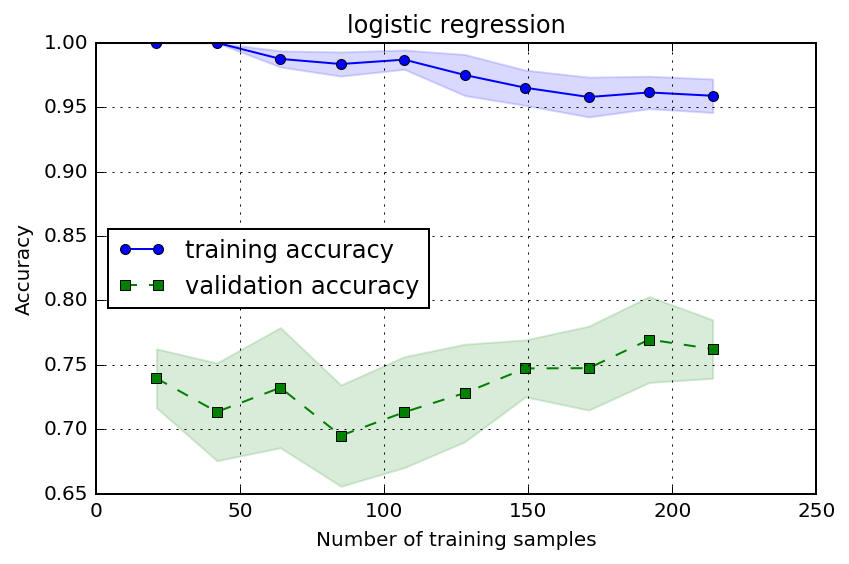

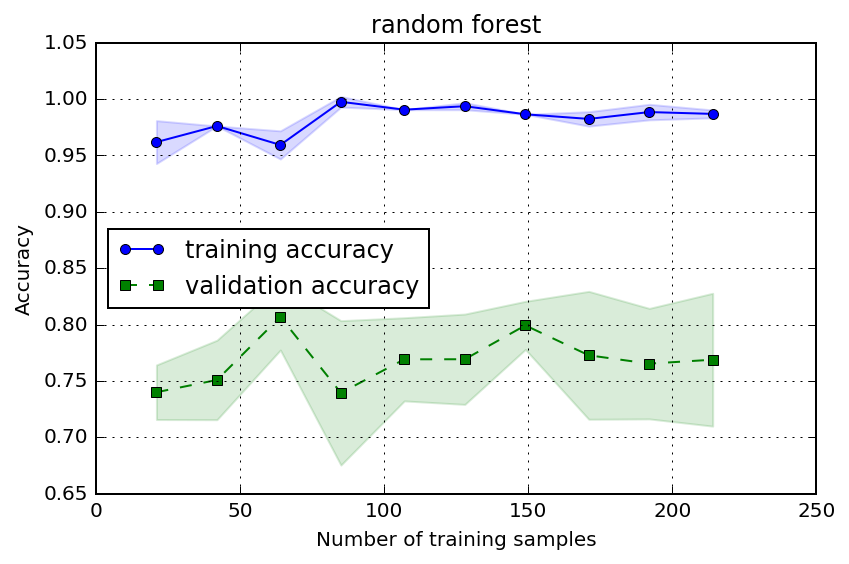

In [44]:
from sklearn.learning_curve import learning_curve

for label, model in models:
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator=model,
        X=X,
        y=y,
        train_sizes=np.linspace(0.1, 1.0, 10),
        cv=5,
        n_jobs=1)
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.plot(train_sizes, train_mean,
             color='blue', marker='o',
             markersize=5, label='training accuracy')

    plt.fill_between(train_sizes,
                     train_mean + train_std,
                     train_mean - train_std,
                     alpha=0.15, color='blue')

    plt.plot(train_sizes, test_mean,
             color='green', linestyle='--',
             marker='s', markersize=5,
             label='validation accuracy')

    plt.fill_between(train_sizes,
                     test_mean + test_std,
                     test_mean - test_std,
                     alpha=0.15, color='green')

    plt.grid()
    plt.title(label)
    plt.xlabel('Number of training samples')
    plt.ylabel('Accuracy')
    plt.legend(loc='center left')
    plt.tight_layout()
    # plt.savefig('./figures/learning_curve.png', dpi=300)
    plt.show()


In [45]:
# from mlxtend.evaluate import plot_decision_regions

# for label, model in models:
#     fig = plot_decision_regions(X=X.as_matrix, y=y,
#                                 clf=model, legend=2)
#     plt.title(label)
    

In [46]:
feat_labels = df_preprocessed.columns

rf_model = pipe_rf.steps[1][1]
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(df_preprocessed.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, feat_labels[f], importances[indices[f]]))

# plt.title('Feature Importances')
# plt.bar(range(df_preprocessed.shape[1]), 
#         importances[indices],
#         color='lightblue', 
#         align='center')

# plt.xticks(range(df_preprocessed.shape[1]), 
#            feat_labels[indices], rotation=90)
# plt.xlim([-1, df_preprocessed.shape[1]])
# plt.tight_layout()
# plt.show()

 1) HomeSEV                        0.085704
 2) Land Improvements Value        0.080317
 3) Land Value                     0.050993
 4) Parcel Acres                   0.048908
 5) PRECINCT                       0.044714
 6) Residential Building Value     0.039267
 7) Year Built                     0.038751
 8) Building Storeys_0             0.037418
 9) Building Storeys_1             0.026886
10) CENBLOCK_                      0.025760
11) CENBLOCK_1                     0.025027
12) CENBLOCK_2                     0.020138
13) CENBLOCK_3                     0.019959
14) CENBLOCK_4                     0.019929
15) CENTRACT_                      0.019582
16) CENTRACT_000400                0.017152
17) CENTRACT_000500                0.016555
18) CENTRACT_000600                0.016409
19) CENTRACT_000800                0.016376
20) CENTRACT_000900                0.015809
21) CENTRACT_001000                0.015706
22) CENTRACT_001100                0.013993
23) CENTRACT_001200             

IndexError: index 103 is out of bounds for axis 0 with size 103